# LightGBM

### Установка необходимых зависимостей

In [1]:
# %pip install lightgbm

In [2]:
# %pip install optuna scikit-learn optuna-integration

In [3]:
# %pip install scipy

In [4]:
# %pip install scikit-optimize

## Импорты

In [5]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
import seaborn as sns
import joblib
import json
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)
from category_encoders import TargetEncoder

from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution

import warnings

warnings.filterwarnings("ignore")

from datetime import timedelta

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

### Определение констант

In [6]:
TARGET_NAME = 'Response'
FILE_PATH = '../data_sources/train.csv' # 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'
CV_FOLDS = 2
RANDOM_STATE = 42
N_JOBS = -1
SCORING='f1'

In [7]:
# Add focal loss function for handling class imbalance
def focal_loss_lgb(y_true, y_pred):
    """
    Custom focal loss for LightGBM
    Helps with imbalanced datasets by focusing on hard-to-classify examples
    """
    alpha = 0.25  # Weight for minority class
    gamma = 2.0   # Focusing parameter
    
    # Convert raw scores to probabilities
    p = 1.0 / (1.0 + np.exp(-y_pred))
    
    # Calculate pt (probability of true class)
    pt = p * y_true + (1 - p) * (1 - y_true)
    
    # Calculate weight factor
    w = alpha * y_true + (1 - alpha) * (1 - y_true)
    w = w * (1 - pt) ** gamma
    
    # Gradient and Hessian for LightGBM
    gradient = w * (p - y_true)
    hessian = w * p * (1 - p) * (1 - gamma * (p - y_true) * (2 * y_true - 1))
    
    return gradient, hessian

In [8]:
class CustomLGBM(lgb.LGBMClassifier):
    # """
    # Wrapper for LightGBM that handles custom objective functions properly
    # """
    # def predict_proba(self, X, raw_score=False, **kwargs):
    #     """
    #     Override predict_proba to handle custom objectives
    #     """
    #     # Get raw predictions
    #     raw_preds = super().predict(X, raw_score=True, **kwargs)
        
    #     # Apply sigmoid to convert to probabilities
    #     probabilities = 1.0 / (1.0 + np.exp(-raw_preds))
        
    #     # Return as 2D array to match sklearn convention
    #     return np.column_stack([1 - probabilities, probabilities])
    
    # def predict(self, X, raw_score=False, **kwargs):
    #     """
    #     Override predict to use threshold of 0.5
    #     """
    #     if raw_score:
    #         return super().predict(X, raw_score=True, **kwargs)
        
    #     # Get probabilities and apply threshold
    #     proba = self.predict_proba(X)[:, 1]
    #     return (proba >= 0.5).astype(int)
    pass

In [9]:
GENERAL_PARAMS = {
    "objective": "binary",
    "boosting_type": "dart",
    "random_state": RANDOM_STATE,
    "n_jobs": N_JOBS,
    "verbosity": -1,
    "is_unbalance": True,
    "metric": "binary_logloss",
    "learning_rate": 0.05,
}

In [10]:
def time_function(func):
    """Decorator to time function execution"""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\n[{time.strftime('%H:%M:%S')}] Запуск: {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"[{time.strftime('%H:%M:%S')}] Завершено {func.__name__} через {timedelta(seconds=int(elapsed))}")
        return result
    return wrapper

In [11]:
def show_evalutation(y_test, y_pred, y_pred_proba):
    print('Оценка модели:')
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(classification_report(y_test, y_pred))
    
    metrics = {
        'Model': 'LightGBM',
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    cm = confusion_matrix(y_test, y_pred)


    print(metrics)
    print(cm)

    sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues"
    )

In [12]:
class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # 1.Соотношение признаков
        X['Age_to_Vintage'] = X['Age'] / (X['Vintage'] + 1)
        X['Premium_to_Age'] = X['Annual_Premium'] / (X['Age'] + 1)
        X['Premium_to_Vintage'] = X['Annual_Premium'] / (X['Vintage'] + 1)
        
        # 2. Группировка по возрасту
        X['Age_Group'] = pd.cut(
            X['Age'],
            bins=[0, 25, 35, 45, 55, 100],
            labels=[1, 2, 3, 4, 5]
        ).astype(float)
        
        # 3. Группировка по премии
        X['Premium_Group'] = pd.qcut(
            X['Annual_Premium'],
            q=5,
            labels=[1, 2, 3, 4, 5],
            duplicates='drop'
        ).astype(float)
        
        # 5. Связь страховки и 
        if 'Previously_Insured' in X.columns and 'Vehicle_Damage' in X.columns:
            X['No_Insurance_But_Damage'] = (
                (X['Previously_Insured'] == 0) & 
                (X['Vehicle_Damage'].astype(str).str.upper() == 'YES')
            ).astype(int)
        
        # 6. Age * Premium interaction
        X['Age_Premium_Interaction'] = X['Age'] * X['Annual_Premium'] / 1000
        
        # 7. Has Driving License and Age (interaction)
        if 'Driving_License' in X.columns:
            X['Licensed_Adult'] = (
                (X['Driving_License'] == 1) & 
                (X['Age'] >= 18)
            ).astype(int)
        
        # 8. Region channel interaction (simple encoding)
        if 'Region_Code' in X.columns and 'Policy_Sales_Channel' in X.columns:
            X['Region_Channel'] = (
                X['Region_Code'].astype(str) + '_' + 
                X['Policy_Sales_Channel'].astype(str)
            )
        
        # 9. Vintage grouping
        X['Vintage_Group'] = pd.cut(
            X['Vintage'],
            bins=[0, 100, 200, 300, 400, 500],
            labels=[1, 2, 3, 4, 5]
        ).astype(float)
        
        # 10. Premium per unit age
        X['Premium_Per_Year'] = X['Annual_Premium'] / (X['Age'] + 1)
        
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return None
        return input_features.tolist() + [
            'Age_to_Vintage', 'Premium_to_Age', 'Premium_to_Vintage',
            'Age_Group', 'Premium_Group',
            'No_Insurance_But_Damage', 'Age_Premium_Interaction',
            'Licensed_Adult', 'Region_Channel', 'Vintage_Group',
            'Premium_Per_Year'
        ]

In [13]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            # Считаем частоты всех категорий
            value_counts = X[col].value_counts(normalize=True)
            
            # Определяем, какие категории встречаются достаточно часто
            common_categories = value_counts[value_counts >= self.threshold].index
            
            # Создаём маппинг для частотного кодирования
            freq_map = {}
            
            # Для частых категорий сохраняем их реальную частоту
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            # Для редких категорий используем суммарную частоту
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            
            freq_map[self.other_name] = other_freq
            
            # Сохраняем маппинг
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            # Создаём временную колонку для преобразований
            temp_col = X_copy[col].astype(str)
            
            # Группируем редкие категории в OTHER
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            # Заменяем редкие категории на OTHER
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            # Применяем частотное кодирование
            encoded_values = temp_col.map(self.freq_maps_[col])
            
            # Заполняем пропуски (новые категории получают частоту OTHER)
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            
            # Заменяем исходную колонку
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

### Загрузка датасета

In [14]:
df = pd.read_csv(FILE_PATH, index_col='id')
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


<a id="fource"></a>
### Разделение датасета

In [15]:
df_sample = df.sample(n=1500000, random_state=RANDOM_STATE)

X = df_sample.drop(TARGET_NAME, axis=1)
y = df_sample[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train: {y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train: Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


### Предобработка признаков

In [16]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel', 'Region_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']
outliers_num_cols = ['Annual_Premium']
num_cols = ['Age', 'Vintage', 'Age_to_Vintage', 'Premium_to_Age', 
            'Premium_to_Vintage', 'Age_Group', 'Premium_Group', 
            'Age_Premium_Interaction', 
            'Vintage_Group', 'Premium_Per_Year']

# New binary features
binary_cols = ['No_Insurance_But_Damage', 'Licensed_Adult']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('outliers_num', RobustScaler(with_centering=True, with_scaling=True), outliers_num_cols),
        ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
        ("binary", 'passthrough', binary_cols),  # Keep binary features as is
    ],
    remainder='drop',  # Drop other columns not specified
    verbose_feature_names_out=False
)

### RandomizedSearchCV

In [17]:
@time_function
def run_randomized_search_cv():
    model_pipeline = Pipeline(
        steps=[
            ("feature_engineering", FeatureEngineeringTransformer()),
            ("preprocessor", preprocessor),
            ("classifier", CustomLGBM(**GENERAL_PARAMS)),
        ]
    )

    cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    lgb_params = {
        "classifier__num_leaves": stats.randint(15, 50),
        "classifier__max_depth": stats.randint(3, 8),
        "classifier__learning_rate": stats.loguniform(0.01, 0.2),
        "classifier__n_estimators": stats.randint(200, 500),
        "classifier__min_child_samples": stats.randint(20, 50),
        "classifier__subsample": stats.uniform(0.7, 0.3),
        "classifier__colsample_bytree": stats.uniform(0.7, 0.3),
        "classifier__reg_alpha": stats.loguniform(1e-3, 1.0),
        "classifier__reg_lambda": stats.loguniform(1e-3, 1.0),
        "classifier__min_split_gain": stats.uniform(0, 0.05),
        # Remove scale_pos_weight since we're using focal loss
        # Add focal loss specific parameters
        # dart-specific params
        "classifier__drop_rate": stats.uniform(0.05, 0.2),
        "classifier__max_drop": stats.randint(20, 100),
    }

    random_search = RandomizedSearchCV(
        estimator=model_pipeline,
        param_distributions=lgb_params,
        n_iter=10,
        cv=cv,
        scoring=SCORING,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
    )

    random_search.fit(X_train, y_train)

    print("\nЛучшие параметры RandomizedSearchCV:")

    for key, value in random_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {random_search.best_score_:.4f}")

    print(f"Сохранение лучших параметров RandomizedSearchCV")
    with open("best_params/best_params_light_gbm_randomized_search.json", "w") as f:
        json.dump(random_search.best_params_, f, indent=4)

    print(f"Сохранение модели с лучшими параметрами")
    joblib.dump(random_search.best_estimator_, f"models/lightgbm_random_search.pkl")

    print(f"Тренировка модели на тесте с лучшими параметрами")
    y_pred = random_search.best_estimator_.predict(X_test)
    y_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba


[08:17:43] Запуск: run_randomized_search_cv...
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Лучшие параметры RandomizedSearchCV:
  classifier__colsample_bytree: 0.7265477506155757
  classifier__drop_rate: 0.08919657248382905
  classifier__learning_rate: 0.011450964268326641
  classifier__max_depth: 7
  classifier__max_drop: 99
  classifier__min_child_samples: 32
  classifier__min_split_gain: 0.013567451588694796
  classifier__n_estimators: 252
  classifier__num_leaves: 38
  classifier__reg_alpha: 0.011756010900231853
  classifier__reg_lambda: 0.006963114377829284
  classifier__subsample: 0.8628088249474745
Best CV score: 0.4445
Сохранение лучших параметров RandomizedSearchCV
Сохранение модели с лучшими параметрами
Тренировка модели на тесте с лучшими параметрами
[08:28:17] Завершено run_randomized_search_cv через 0:10:33
Оценка модели:
ROC-AUC: 0.8534
              precision    recall  f1-score   support

           0       0.98      0.70      0.82    438397
         

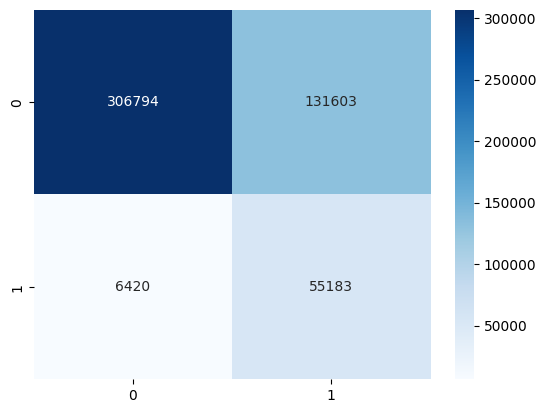

In [18]:
rscv_pred, rscv_pred_proba = run_randomized_search_cv()
show_evalutation(y_test, rscv_pred, rscv_pred_proba)

### Optuna

In [19]:
@time_function
def run_optuna_searchcv(n_trials=15):
    param_distributions = {
        "classifier__num_leaves": IntDistribution(15, 20),
        "classifier__max_depth": IntDistribution(3, 8),
        "classifier__learning_rate": FloatDistribution(0.01, 0.2),
        "classifier__n_estimators": IntDistribution(200, 500),
        "classifier__min_child_samples": IntDistribution(20, 50),
        "classifier__subsample": FloatDistribution(0.3, 0.7),
        "classifier__colsample_bytree": FloatDistribution(0.3, 0.7),
        "classifier__reg_alpha": FloatDistribution(1e-3, 1.0),
        "classifier__reg_lambda": FloatDistribution(1e-3, 1.0),
        "classifier__min_split_gain": FloatDistribution(0, 0.05),
        # Remove scale_pos_weight
        # dart-specific params
        "classifier__drop_rate": FloatDistribution(0.05, 0.2),
        "classifier__max_drop": IntDistribution(20, 100),
    }

    pipeline = Pipeline(
        [
            ("feature_engineering", FeatureEngineeringTransformer()),
            ("preprocessor", preprocessor),
            ("classifier", lgb.LGBMClassifier(**GENERAL_PARAMS)),
        ]
    )

    optuna_search = OptunaSearchCV(
        estimator=pipeline,
        param_distributions=param_distributions,
        n_trials=n_trials,
        cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
        scoring=SCORING,
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
        enable_pruning=False,
    )

    print(f"Starting OptunaSearchCV with {n_trials} trials...")
    optuna_search.fit(X_train, y_train)

    print("\nBest parameters from OptunaSearchCV:")
    for key, value in optuna_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {optuna_search.best_score_:.4f}")

    print("Сохранение лучших параметров")
    with open("best_params/best_params_ligth_gbm_optuna_searchcv.json", "w") as f:
        json.dump(optuna_search.best_params_, f, indent=4)

    print("Сохранение лучшей модели")
    joblib.dump(optuna_search.best_estimator_, "models/lightgbm_optuna_searchcv.pkl")

    print("Оценка на тестовом наборе")
    y_pred = optuna_search.predict(X_test)
    y_pred_proba = optuna_search.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba

[I 2025-12-20 08:28:19,019] A new study created in memory with name: no-name-2a02a42c-09a7-482b-8e60-3e8d93fb0650



[08:28:18] Запуск: run_optuna_searchcv...
Starting OptunaSearchCV with 15 trials...


[I 2025-12-20 08:32:10,956] Trial 9 finished with value: 0.4304733737272233 and parameters: {'classifier__num_leaves': 20, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.04672133073644779, 'classifier__n_estimators': 277, 'classifier__min_child_samples': 44, 'classifier__subsample': 0.6550501057303291, 'classifier__colsample_bytree': 0.5051587099741466, 'classifier__reg_alpha': 0.8426501659131992, 'classifier__reg_lambda': 0.1976913378388221, 'classifier__min_split_gain': 0.04909316590663909, 'classifier__drop_rate': 0.07533026365042507, 'classifier__max_drop': 25}. Best is trial 9 with value: 0.4304733737272233.
[I 2025-12-20 08:33:14,696] Trial 8 finished with value: 0.43473579672179763 and parameters: {'classifier__num_leaves': 19, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.026027172752705857, 'classifier__n_estimators': 332, 'classifier__min_child_samples': 24, 'classifier__subsample': 0.6134643623355674, 'classifier__colsample_bytree': 0.449066037452118


Best parameters from OptunaSearchCV:
  classifier__num_leaves: 18
  classifier__max_depth: 5
  classifier__learning_rate: 0.15934305495510623
  classifier__n_estimators: 474
  classifier__min_child_samples: 50
  classifier__subsample: 0.638489928941648
  classifier__colsample_bytree: 0.6912669970351991
  classifier__reg_alpha: 0.6588204164026131
  classifier__reg_lambda: 0.13312097497036254
  classifier__min_split_gain: 0.02141164398240132
  classifier__drop_rate: 0.11296525814679949
  classifier__max_drop: 34
Best CV score: 0.4401
Сохранение лучших параметров
Сохранение лучшей модели
Оценка на тестовом наборе
[08:42:37] Завершено run_optuna_searchcv через 0:14:19
Оценка модели:
ROC-AUC: 0.8645
              precision    recall  f1-score   support

           0       0.99      0.68      0.80    438397
           1       0.29      0.93      0.44     61603

    accuracy                           0.71    500000
   macro avg       0.64      0.80      0.62    500000
weighted avg       0.90

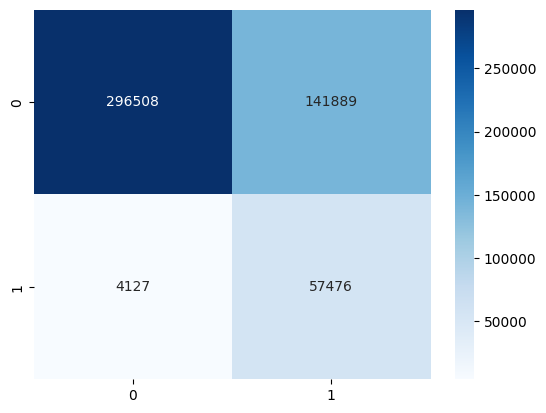

In [20]:
optuna_pred, optuna_pred_proba = run_optuna_searchcv()
show_evalutation(y_test, optuna_pred, optuna_pred_proba)

In [21]:
@time_function
def run_bayes_searchcv(n_trials=15):
    search_spaces = {
        "classifier__num_leaves": Integer(15, 50),
        "classifier__max_depth": Integer(3, 8),
        "classifier__learning_rate": Real(0.01, 0.2, prior="log-uniform"),
        "classifier__n_estimators": Integer(200, 500),
        "classifier__min_child_samples": Integer(20, 50),
        "classifier__subsample": Real(0.3, 0.7),
        "classifier__colsample_bytree": Real(0.3, 0.7),
        "classifier__reg_alpha": Real(1e-3, 1.0, prior="log-uniform"),
        "classifier__reg_lambda": Real(1e-3, 1.0, prior="log-uniform"),
        "classifier__min_split_gain": Real(0, 0.05),
        # dart-specific params
        "classifier__drop_rate": Real(0.05, 0.2),
        "classifier__max_drop": Integer(20, 100),
    }

    pipeline = Pipeline(
        [
            ("feature_engineering", FeatureEngineeringTransformer()),
            ("preprocessor", preprocessor),
            ("classifier", CustomLGBM(**GENERAL_PARAMS)),
        ]
    )

    bayes_search = BayesSearchCV(
        estimator=pipeline,
        search_spaces=search_spaces,
        n_iter=n_trials,
        cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE),
        scoring="f1",
        n_jobs=N_JOBS,
        random_state=RANDOM_STATE,
        verbose=1,
    )

    print(f"Starting BayesSearchCV with {n_trials} trials...")
    bayes_search.fit(X_train, y_train)

    print("\nBest parameters from OptunaSearchCV:")
    for key, value in bayes_search.best_params_.items():
        print(f"  {key}: {value}")
    print(f"Best CV score: {bayes_search.best_score_:.4f}")

    print("Сохранение лучших параметров")
    with open("best_params/best_params_ligth_gbm_bayes_searchcv.json", "w") as f:
        json.dump(bayes_search.best_params_, f, indent=4)

    print("Сохранение лучшей модели")
    joblib.dump(bayes_search.best_estimator_, "models/lightgbm_bayes_searchcv.pkl")

    print("Оценка на тестовом наборе")
    y_pred = bayes_search.predict(X_test)
    y_pred_proba = bayes_search.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba


[08:42:39] Запуск: run_bayes_searchcv...
Starting BayesSearchCV with 15 trials...
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits

Best parameters from OptunaSear

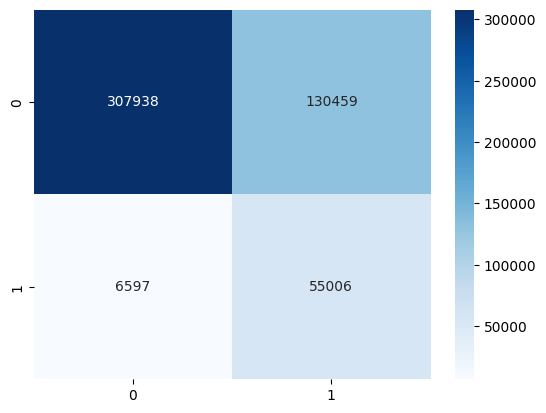

In [22]:
bayes_pred, bayes_pred_proba = run_bayes_searchcv()
show_evalutation(y_test, bayes_pred, bayes_pred_proba)

Оценка на тестовом наборе
Оценка модели:
ROC-AUC: 0.8673
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    438397
           1       0.59      0.05      0.09     61603

    accuracy                           0.88    500000
   macro avg       0.74      0.52      0.51    500000
weighted avg       0.85      0.88      0.83    500000

{'Model': 'LightGBM', 'Precision': 0.5895508000771159, 'Recall': 0.04964043958898105, 'F1': 0.09157059440035933, 'ROC-AUC': 0.8672898952325174}
[[436268   2129]
 [ 58545   3058]]


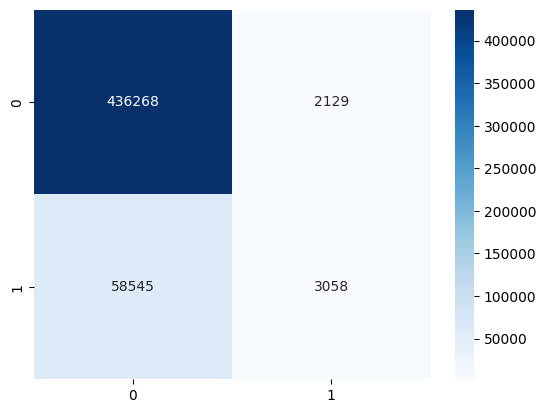

In [23]:
final_model = Pipeline(
    steps=[
        ("feature_engineering", FeatureEngineeringTransformer()),
        ("preprocessor", preprocessor),
        (
            "classifier",
            lgb.LGBMClassifier(
                # **GENERAL_PARAMS,
                **{
                    "classifier__num_leaves": 60,
                    "classifier__max_depth": 11,
                    "classifier__learning_rate": 0.003921725897556518,
                    "classifier__n_estimators": 313,
                    "classifier__min_child_samples": 44,
                    "classifier__subsample": 0.5980826035923351,
                    "classifier__colsample_bytree": 0.8567087250415494,
                    "classifier__reg_alpha": 0.0007006048753498594,
                    "classifier__reg_lambda": 3.3900135924229895e-06,
                    "classifier__min_split_gain": 0.06636185701682451,
                    "classifier__scale_pos_weight": 7.771233981055667,
                    # "is_unbalance": True,
                    "objective": "binary",
                    "boosting_type": "gbdt",  # better for imbalance
                    "metric": "auc",
                    "random_state": RANDOM_STATE,
                    "n_jobs": N_JOBS,
                    "verbosity": -1,
                }
            ),
        ),
    ]
)

final_model.fit(X_train, y_train)
print("Оценка на тестовом наборе")
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]
show_evalutation(y_test, y_pred, y_pred_proba)

In [24]:
def analyze_feature_importance(model_pipeline, X_train, y_train, feature_names=None):
    model_pipeline.fit(X_train, y_train)
    
    classifier = model_pipeline.named_steps['classifier']
    
    preprocessor = model_pipeline.named_steps['preprocessor']
    
    try:
        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out()
    except:
        pass
    
    importances = classifier.feature_importances_
    
    if feature_names is not None and len(feature_names) == len(importances):
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
        
        print("Топ 20 самых важных признаков:")
        print(feature_importance_df.head(20))
        
        plt.figure(figsize=(10, 8))
        top_n = min(20, len(feature_importance_df))
        plt.barh(range(top_n), feature_importance_df['Importance'].head(top_n)[::-1])
        plt.yticks(range(top_n), feature_importance_df['Feature'].head(top_n)[::-1])
        plt.xlabel('Importance')
        plt.title('Top Feature Importances')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Number of features: {len(importances)}")
        print("Top 20 feature importances:")
        for i in range(min(20, len(importances))):
            print(f"Feature {i}: {importances[i]:.6f}")
    
    return importances

Топ 20 самых важных признаков:
                    Feature  Importance
1                   Vintage        1053
0                       Age         372
14           Region_Channel         364
8   Age_Premium_Interaction         232
11           Annual_Premium         225
7       Vehicle_Age_Numeric         208
3            Premium_to_Age         157
2            Age_to_Vintage         125
4        Premium_to_Vintage         103
18  No_Insurance_But_Damage          60
15              Gender_Male          47
16       Vehicle_Damage_Yes          30
19           Licensed_Adult          18
9             Vintage_Group           3
6             Premium_Group           2
5                 Age_Group           1
10         Premium_Per_Year           0
13     Policy_Sales_Channel           0
12              Region_Code           0
17              Vehicle_Age           0


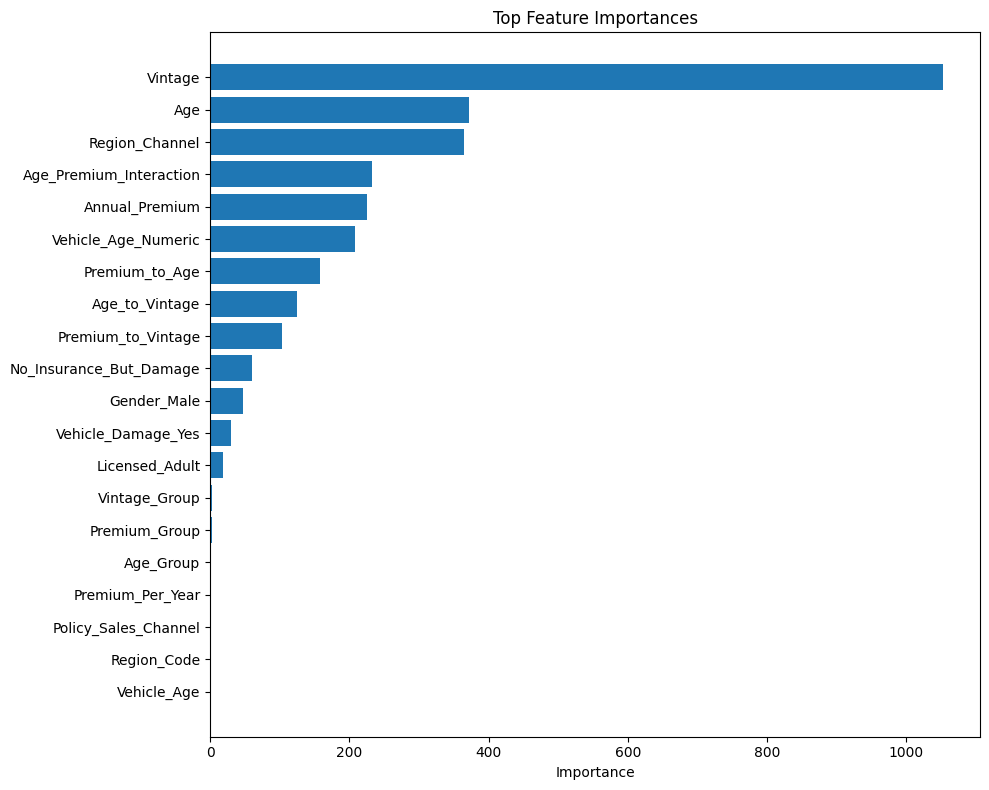

array([ 372, 1053,  125,  157,  103,    1,    2,  208,  232,    3,    0,
        225,    0,    0,  364,   47,   30,    0,   60,   18], dtype=int32)

In [25]:
analyze_feature_importance(final_model, X_train, y_train)